In [1]:
# 適宜自分のApplicationPATHまで変更
APP_PATH = "/root"

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import japanize_matplotlib
from IPython.display import display
from torchinfo import summary
from torchviz import make_dot

import os
import sys
import cv2
from PIL import Image
import pandas as pd

In [2]:
# GPUの確認

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# 画像データ(npzのバイナリファイル)の読み込み

# 対物レンズ10倍。
# 入力サイズ960px
# x.1の画像のみのデータセット


datasets_npz_x1 = np.load(APP_PATH + "/dataset_npz/x.1_dataset/sc_x10_960_x1.npz")
# datasets_npz_x3 = np.load(APP_PATH + '/dataset_npz/x.1_dataset/sc_x10_960_x1.npz')
# datasets_npz_all = np.load(APP_PATH + '/dataset_npz/x.1_dataset/sc_x10_960_x1.npz')

# 256なのでこちらを使う
# datasets_npz_x1 = np.load(APP_PATH + '/dataset_npz/x.3_dataset/x5/sc_x5_1.npz')


CATEGORIES = ["S10C", "S15C", "S25C", "S35C", "S45C", "S55C"]

classes = ("S10C", "S15C", "S25C", "S35C", "S45C", "S55C")


# Xはdata, Yはtargetのこと
# print(datasets_npz_x1)
# print(datasets_npz_x1.files)

# データを3次元のtensor([c h w])に変換(1次元と3次元で比較)
images = datasets_npz_x1["x"]
labels = datasets_npz_x1["y"]

# transpose_images = np.empty(shape=1, dtype=float)
# print("transpose_images: {}".format(transpose_images))
images_list = []
labels_list = []

# NUM_DATA = 10
# NUM_DATA = 60
# NUM_DATA = 120
NUM_DATA = 290

# 正規化手法定義 MinMaxScaler(0<=data<=1)
mmscaler = preprocessing.MinMaxScaler()

for i, image in enumerate(images):
    # CPUが使い果たされてしまうので200までを使用
    if i == NUM_DATA:
        break

    print(f"image: ")
    print(image)

    image = Image.fromarray(image)
    # print("image dtype: {}".format(type(image)))
    image = image.convert("RGB")

    # 32x32にリサイズ
    image = image.resize((256, 256))

    # print("image mode: {}".format(image.mode)) # むりやり3チャンネルにしているので表記上はRGBだが実際はL
    # PIL前に正規化をするとバグる
    image = np.asarray(image, np.float32)

    # 正規化
    # 次元が2以上なので使えない
    # image = mmscaler.fit_transform(image)
    image = image.astype(float) / 255.0
    print(f"image transform: ")
    print(image)

    # print("image shape: {}".format(image.shape))
    image = np.transpose(image, (2, 0, 1))
    print("image transpose shape: {}".format(image.shape))
    # transpose_images = np.append(transpose_images, image, axis=0)
    images_list.append(image)
    labels_list.append(labels[i])

    print(i, "/", len(images))


transpose_images = np.array(images_list)
transpose_labels = np.array(labels_list)

# うまくいっていたら保存
print("transpose_images dtype: {}".format(type(transpose_images)))
print("transpose_images shape: {}".format(transpose_images.shape))
print("transpose_images: {}".format(transpose_images))

print("transpose_labels dtype: {}".format(type(transpose_labels)))
print("transpose_labels shape: {}".format(transpose_labels.shape))
print("transpose_labels: {}".format(transpose_labels))
np.savez(APP_PATH, "data/temp/np_savez", transpose_images, datasets_npz_x1["y"])

# image = Image.fromarray(image)
# print("image dtype: {}".format(type(image)))
# image = image.convert("RGB")
# print("image mode: {}".format(image.mode)) # むりやり3チャンネルにしているので表記上はRGBだが実際はL
# image = np.asarray(image, np.uint8)
# print("image shape: {}".format(image.shape))
# image = np.transpose(image, (2, 0, 1))
# print("image transpose shape: {}".format(image.shape))

image: 
[[ 65  54  47 ... 117 119 115]
 [ 74  62  53 ... 110 115 107]
 [ 74  88 112 ... 115 113 111]
 ...
 [ 80  79  89 ...  90  98 134]
 [ 84  82 100 ... 239 240 235]
 [ 85  84 103 ... 238 236 236]]
image transform: 
[[[0.28235294 0.28235294 0.28235294]
  [0.29411765 0.29411765 0.29411765]
  [0.28235294 0.28235294 0.28235294]
  ...
  [0.48627451 0.48627451 0.48627451]
  [0.4745098  0.4745098  0.4745098 ]
  [0.44313725 0.44313725 0.44313725]]

 [[0.34901961 0.34901961 0.34901961]
  [0.31764706 0.31764706 0.31764706]
  [0.37647059 0.37647059 0.37647059]
  ...
  [0.46666667 0.46666667 0.46666667]
  [0.44313725 0.44313725 0.44313725]
  [0.38823529 0.38823529 0.38823529]]

 [[0.44313725 0.44313725 0.44313725]
  [0.3372549  0.3372549  0.3372549 ]
  [0.40392157 0.40392157 0.40392157]
  ...
  [0.4627451  0.4627451  0.4627451 ]
  [0.39215686 0.39215686 0.39215686]
  [0.37254902 0.37254902 0.37254902]]

 ...

 [[0.76470588 0.76470588 0.76470588]
  [0.68627451 0.68627451 0.68627451]
  [0.6156862

In [4]:
# transformsなしの自作のデータセット作成
data = torch.tensor(transpose_images, dtype=torch.float32)
label = torch.tensor(transpose_labels, dtype=torch.int64)

print("data.shape:", data.shape, "label.shape:", label.shape)

# Datasetを作成
dataset = torch.utils.data.TensorDataset(data, label)

X_sample, y_sample = dataset[0]
print(X_sample.shape, y_sample.shape)
print(X_sample)
print(y_sample)


# transformsを使ったrailにのったやり方(自作クラスを後に作成する)
# https://dreamer-uma.com/pytorch-dataset/

data.shape: torch.Size([290, 3, 256, 256]) label.shape: torch.Size([290])
torch.Size([3, 256, 256]) torch.Size([])
tensor([[[0.2824, 0.2941, 0.2824,  ..., 0.4863, 0.4745, 0.4431],
         [0.3490, 0.3176, 0.3765,  ..., 0.4667, 0.4431, 0.3882],
         [0.4431, 0.3373, 0.4039,  ..., 0.4627, 0.3922, 0.3725],
         ...,
         [0.7647, 0.6863, 0.6157,  ..., 0.5843, 0.6157, 0.4824],
         [0.6314, 0.5529, 0.5020,  ..., 0.7098, 0.6196, 0.5176],
         [0.3765, 0.3882, 0.5216,  ..., 0.6039, 0.5961, 0.6745]],

        [[0.2824, 0.2941, 0.2824,  ..., 0.4863, 0.4745, 0.4431],
         [0.3490, 0.3176, 0.3765,  ..., 0.4667, 0.4431, 0.3882],
         [0.4431, 0.3373, 0.4039,  ..., 0.4627, 0.3922, 0.3725],
         ...,
         [0.7647, 0.6863, 0.6157,  ..., 0.5843, 0.6157, 0.4824],
         [0.6314, 0.5529, 0.5020,  ..., 0.7098, 0.6196, 0.5176],
         [0.3765, 0.3882, 0.5216,  ..., 0.6039, 0.5961, 0.6745]],

        [[0.2824, 0.2941, 0.2824,  ..., 0.4863, 0.4745, 0.4431],
        

In [5]:
# DataLoader ミニバッチ学習
# 入力値と目標値をまとめる


# 学習データ、検証データ、テストデータに分ける
# 各データセットのサンプル数を決定
# train : val : test = 60% : 20% : 20%
num_train = int(len(dataset) * 0.8)
# num_val = int(len(dataset) * 0.2)
num_test = int(len(dataset) - num_train)

print("num_train:", num_train)
# print('num_val:', num_val)
print("num_test:", num_test)

# ランダムにするらめにシードの固定をした
torch.manual_seed(0)
# データセットの分割
train, test = torch.utils.data.random_split(dataset, [num_train, num_test])
print("train:", train)
# print('val:', val)
print("test:", test)


# 一括でデータを作成
# train_X, test_X, train_y, test_y = train_test_split(X, y, test_size
# =0.8, random_state=1)

num_train: 232
num_test: 58
train: <torch.utils.data.dataset.Subset object at 0x7f927fe651e0>
test: <torch.utils.data.dataset.Subset object at 0x7f927fe65150>


In [6]:
# ミニバッチ学習

# バッチサイズの定義(目安は全データの1/10だが正解がない)
# batch_size = 2
# batch_size = 6
batch_size = 18

train_loader = torch.utils.data.DataLoader(
    train, batch_size, shuffle=True, drop_last=True
)
# val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

# 1つ目のバッチサイズに分割したデータを確認
x, t = next(iter(train_loader))

print("x:", x)
print("t:", t)

x: tensor([[[[0.3020, 0.5098, 0.6706,  ..., 0.6196, 0.6000, 0.4627],
          [0.4667, 0.6353, 0.6667,  ..., 0.6235, 0.6314, 0.6314],
          [0.6549, 0.6667, 0.6745,  ..., 0.6706, 0.6706, 0.6510],
          ...,
          [0.6627, 0.6471, 0.6392,  ..., 0.7059, 0.7059, 0.7059],
          [0.6706, 0.6627, 0.6353,  ..., 0.6980, 0.7020, 0.7020],
          [0.6588, 0.6745, 0.6431,  ..., 0.6392, 0.5765, 0.7098]],

         [[0.3020, 0.5098, 0.6706,  ..., 0.6196, 0.6000, 0.4627],
          [0.4667, 0.6353, 0.6667,  ..., 0.6235, 0.6314, 0.6314],
          [0.6549, 0.6667, 0.6745,  ..., 0.6706, 0.6706, 0.6510],
          ...,
          [0.6627, 0.6471, 0.6392,  ..., 0.7059, 0.7059, 0.7059],
          [0.6706, 0.6627, 0.6353,  ..., 0.6980, 0.7020, 0.7020],
          [0.6588, 0.6745, 0.6431,  ..., 0.6392, 0.5765, 0.7098]],

         [[0.3020, 0.5098, 0.6706,  ..., 0.6196, 0.6000, 0.4627],
          [0.4667, 0.6353, 0.6667,  ..., 0.6235, 0.6314, 0.6314],
          [0.6549, 0.6667, 0.6745,  ...

In [7]:
# 2.3 ニューラルネットワークの定義

num_classes = 6  # CIFAR10のクラスの数を指定

# n_input = 32 * 32 * 3 # 全結合するために使用する
n_input = 960 * 960 * 3  # 全結合するために使用する
n_output = 6
# 中間層のノード数(何でもよい：調べる必要あり)
# n_hidden = 128
n_hidden = 128


# https://www.youtube.com/watch?v=6roIEgXy7wA
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.maxpool = nn.MaxPool2d((2, 2))
        # self.flatten = nn.Flatten()
        # self.flatten = nn.Flatten()
        # self.l1 = nn.Linear(54378240, n_hidden)
        # self.l1 = nn.Linear(10875648, n_hidden)# btchsize 6
        # self.l1 = nn.Linear(3625216, n_hidden) # btchsize 2

        self.l1 = nn.Linear(738048, n_hidden)  # btchsize 6(256)
        self.l1 = nn.Linear(6912, n_hidden)  # btchsize 6(256)　32にリサイズ

        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    # 順伝搬を定義
    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = torch.flatten(x)
        x = self.relu(self.l1(x))
        x = self.l2(x)
        return x


# flattenに入れる前の入力画像(特徴MAP)のサイズ確認
# conv1 = nn.Conv2d(3, 32, 3)
# conv2 = nn.Conv2d(32, 32, 3)
# maxpool = nn.MaxPool2d((2, 2))
# relu = nn.ReLU(inplace=True)

# x = maxpool(relu(conv1(x)))
# x = maxpool(relu(conv2(x)))
# x = torch.flatten(x)

# print("x shape: {}".format(x.shape))


# 参考書どおり
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        # self.l1 = nn.Linear(7311488, n_hidden)
        self.l1 = nn.Linear(6272, n_hidden)  # 32
        self.l1 = nn.Linear(508032, n_hidden)  # 256

        self.l2 = nn.Linear(n_hidden, n_output)

        self.features = nn.Sequential(
            self.conv1, self.relu, self.conv2, self.relu, self.maxpool
        )

        self.classifier = nn.Sequential(self.l1, self.relu, self.l2)

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3


# (6, 3, 960, 960)
# (6, 3, 32, 32)
print("x before shape: {}".format(x.shape))

# flattenに入れる前の入力画像(特徴MAP)のサイズ確認
conv1 = nn.Conv2d(3, 32, 3)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2, 2))
relu = nn.ReLU(inplace=True)

x1 = conv1(x)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

print("x1 shape: {}".format(x1.shape))
print("x2 shape: {}".format(x2.shape))
print("x3 shape: {}".format(x3.shape))
print("x4 shape: {}".format(x4.shape))
print("x5 shape: {}".format(x5.shape))

features = nn.Sequential(conv1, relu, conv2, relu, maxpool)

outputs = features(x)
print(outputs)

flatten = nn.Flatten()
outputs2 = flatten(outputs)

print("outputs shape: {}".format(outputs.shape))
print("outputs2 shape: {}".format(outputs2.shape))

# ネットワークのロード
net = CNN(n_output, n_hidden).to(device)
print(net)

x before shape: torch.Size([18, 3, 256, 256])
x1 shape: torch.Size([18, 32, 254, 254])
x2 shape: torch.Size([18, 32, 254, 254])
x3 shape: torch.Size([18, 32, 252, 252])
x4 shape: torch.Size([18, 32, 252, 252])
x5 shape: torch.Size([18, 32, 126, 126])
tensor([[[[9.0683e-02, 8.1899e-02, 1.0534e-01,  ..., 9.2731e-03,
           8.8473e-02, 9.5239e-02],
          [8.8819e-02, 8.0906e-02, 9.2251e-02,  ..., 1.1535e-01,
           9.1085e-02, 9.1561e-02],
          [7.2406e-02, 5.0619e-02, 1.1729e-02,  ..., 9.1749e-02,
           9.4539e-02, 6.5011e-02],
          ...,
          [7.5768e-02, 9.4550e-02, 5.6953e-02,  ..., 5.9323e-02,
           4.4486e-02, 2.4241e-02],
          [7.0692e-02, 8.8108e-02, 1.0023e-01,  ..., 0.0000e+00,
           7.4513e-02, 9.4315e-02],
          [1.0144e-01, 8.4939e-02, 1.1176e-01,  ..., 1.4809e-02,
           6.3334e-02, 9.0527e-02]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.

In [8]:
# 2.4 損失関数と最適化関数の定義

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 活性化関数の定義(最適化アルゴリズムの設定(確率的勾降下法))
lr = 0.01
# lr = 0.001
# lr = 0.0001

# GPUの関係で使えない(Errorになる)
optimizer = optim.Adam(net.parameters())
# optimizer = optim.SGD(net.parameters(), lr=lr)

In [9]:
# 学習用関数
def fit(
    net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history
):
    # tqdmライブラリのインポート
    from tqdm import tqdm

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs + base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        # 訓練フェーズ
        net.train()

        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size

            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size
            n_train_acc += (predicted == labels).sum().item()

        # 予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)

            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss += loss_test.item() * test_batch_size
            n_val_acc += (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print(
            f"Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}"
        )
        # 記録
        item = np.array([epoch + 1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history


num_epochs = 100
history = np.zeros((0, 5))


history = fit(
    net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history
)

Epoch [1/100], loss: 12.29060 acc: 0.13889 val_loss: 1.78968, val_acc: 0.25862
Epoch [2/100], loss: 1.70931 acc: 0.20370 val_loss: 1.59929, val_acc: 0.24138
Epoch [3/100], loss: 1.46391 acc: 0.37963 val_loss: 2.01164, val_acc: 0.15517
Epoch [4/100], loss: 1.16016 acc: 0.61574 val_loss: 1.44923, val_acc: 0.31034
Epoch [5/100], loss: 0.51883 acc: 0.82870 val_loss: 1.58168, val_acc: 0.44828
Epoch [6/100], loss: 0.23358 acc: 0.94907 val_loss: 1.62515, val_acc: 0.37931
Epoch [7/100], loss: 0.09951 acc: 0.98148 val_loss: 1.33632, val_acc: 0.53448
Epoch [8/100], loss: 0.05415 acc: 1.00000 val_loss: 2.68420, val_acc: 0.31034
Epoch [9/100], loss: 0.01728 acc: 1.00000 val_loss: 1.10083, val_acc: 0.62069
Epoch [10/100], loss: 0.00260 acc: 1.00000 val_loss: 1.14114, val_acc: 0.48276
Epoch [11/100], loss: 0.00147 acc: 1.00000 val_loss: 1.63014, val_acc: 0.37931
Epoch [12/100], loss: 0.00098 acc: 1.00000 val_loss: 1.18976, val_acc: 0.48276
Epoch [13/100], loss: 0.00064 acc: 1.00000 val_loss: 1.18258

In [10]:
# 学習ログ解析


def evaluate_history(history):
    # 損失と精度の確認
    print(f"初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}")
    print(f"最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}")

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9, 8))
    plt.plot(history[:, 0], history[:, 1], "b", label="訓練")
    plt.plot(history[:, 0], history[:, 3], "k", label="検証")
    plt.xticks(np.arange(0, num_epochs + 1, unit))
    plt.xlabel("繰り返し回数")
    plt.ylabel("損失")
    plt.title("学習曲線(損失)")
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9, 8))
    plt.plot(history[:, 0], history[:, 2], "b", label="訓練")
    plt.plot(history[:, 0], history[:, 4], "k", label="検証")
    plt.xticks(np.arange(0, num_epochs + 1, unit))
    plt.xlabel("繰り返し回数")
    plt.ylabel("精度")
    plt.title("学習曲線(精度)")
    plt.legend()
    plt.show()

In [11]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
        # デバイスの割り当て
        inputs = images.to(device)
        labels = labels.to(device)

        # 予測計算
        outputs = net(inputs)
        predicted = torch.max(outputs, 1)[1]
        # images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
            predicted_name = classes[predicted[i]]
            # 正解かどうかで色分けをする
            if label_name == predicted_name:
                c = "k"
            else:
                c = "b"
            ax.set_title(label_name + ":" + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
            ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1) / 2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

初期状態: 損失: 1.78968 精度: 0.25862
最終状態: 損失: 1.23465 精度: 0.39655


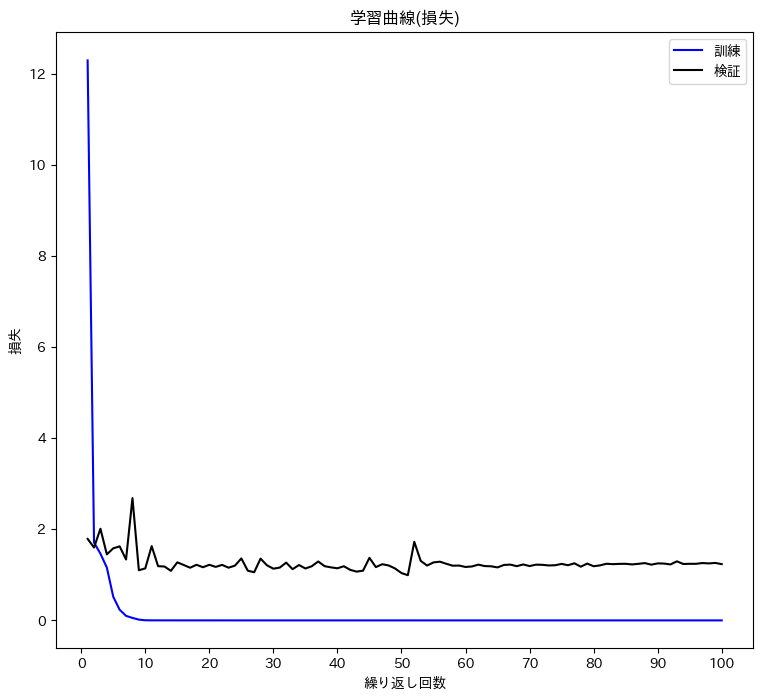

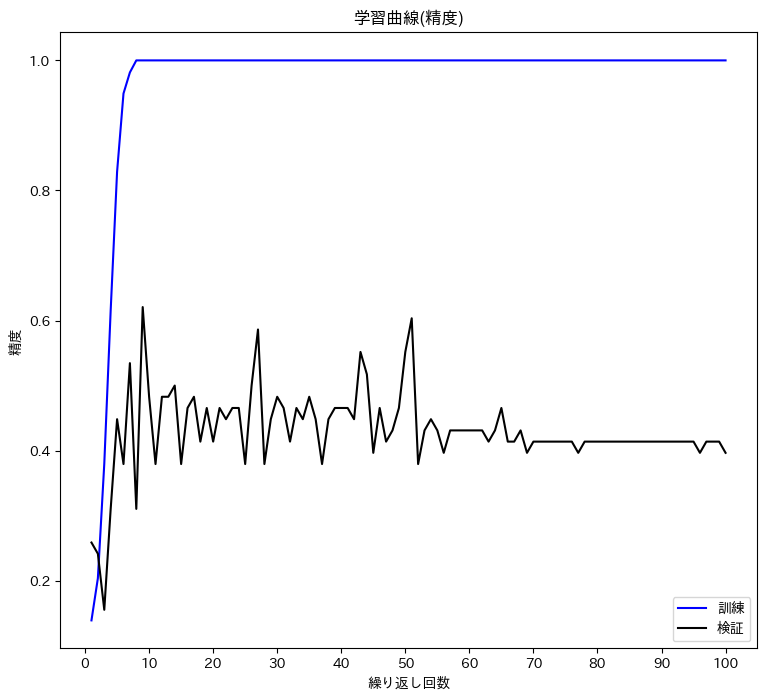

In [12]:
# 評価

evaluate_history(history)

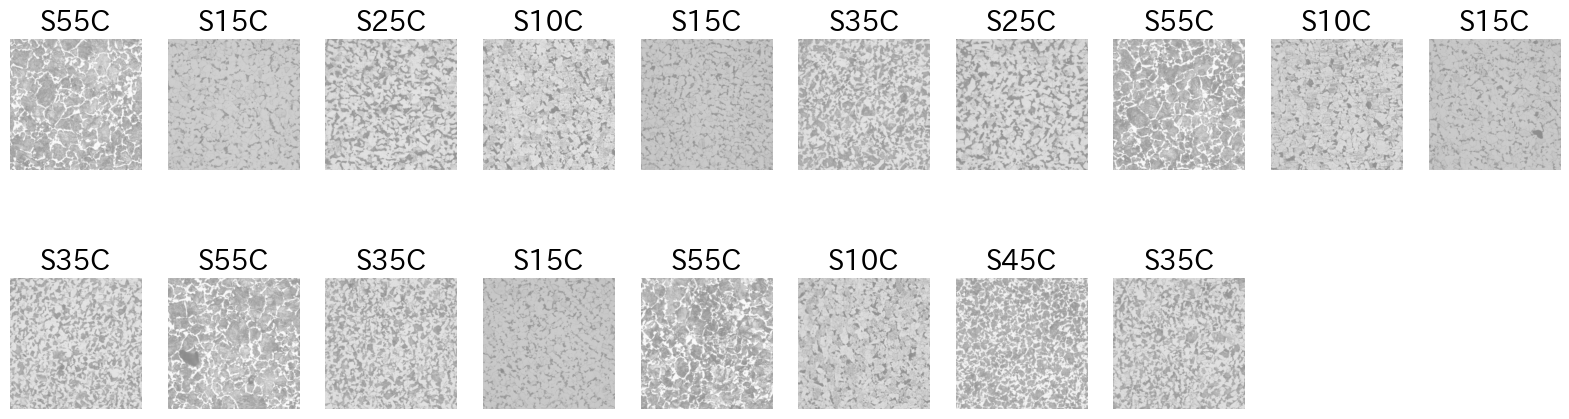

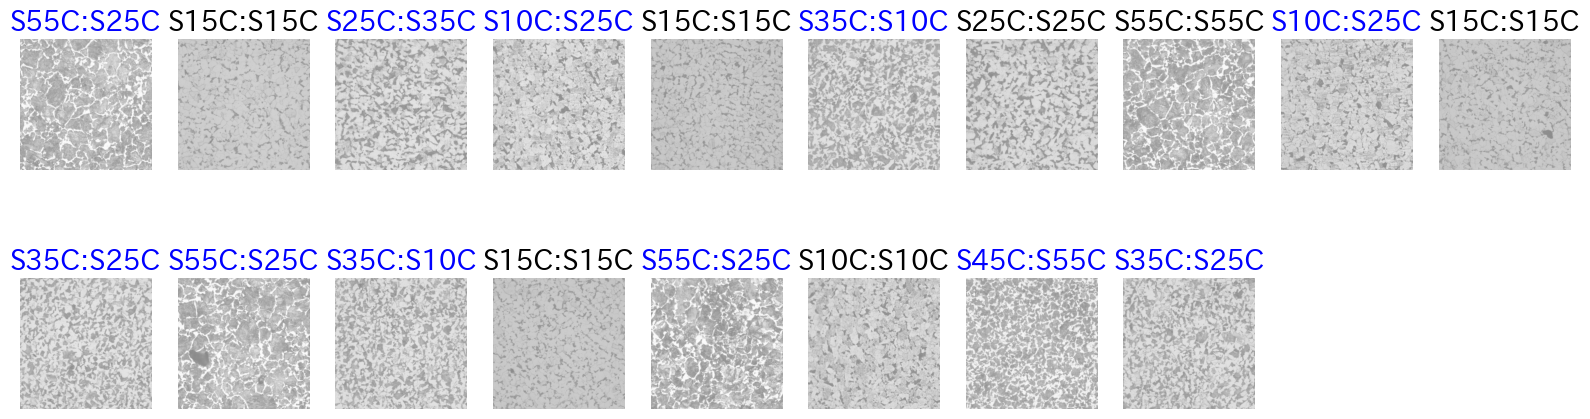

In [13]:
# 最初の50個の表示

show_images_labels(test_loader, classes, None, device)
show_images_labels(test_loader, classes, net, device)

In [14]:
# # 2.5 学習

# # 損失と正解率を保持するリストを作成
# train_loss_list = []        # 学習損失
# train_accuracy_list = []    # 学習データの正答率
# test_loss_list = []         # 評価損失
# test_accuracy_list = []     # テストデータの正答率

# # 学習(エポック)の実行
# epoch = 30
# # epoch = 1
# for i in range(epoch):
#     # エポックの進行状況を表示
#     print("-------------------------------")
#     print("Epoch: {}/{}".format(i+1, epoch))

#     # 損失と正解率の初期化
#     train_loss = 0      # 学習損失
#     train_accuracy = 0  # 学習データの正答率
#     test_loss = 0       # 評価損失
#     test_accuracy = 0   # テストデータの正答率

#     # ---------学習パート--------- #
#     # ニューラルネットワークを学習モードに設定
#     net.train()
#     # ミニバッチごとにデータをロードし学習
#     for images, labels in train_loader:
#         # GPUにTensorを転送
#         images = images.to(device)
#         labels = labels.to(device)

#         # 勾配を初期化
#         optimizer.zero_grad()
#         # データを入力して予測値を計算(順伝播)
#         y_pred_prob = net(images)
#         # 損失(誤差)を計算
#         # print(f'y_pred_prob: ')
#         # print(y_pred_prob)
#         # print(f'labels: ')
#         # print(labels)
#         # print(type(labels))

#         # 正解クラスを確率分布に変換
#         # labels_one_hot = F.one_hot(labels, num_classes=6).float()

#         # labels_float = labels.float()
#         # print(labels_float)

#         loss = criterion(y_pred_prob, labels)
#         # loss = criterion(y_pred_prob, labels_float)
#         # 勾配の計算(逆伝搬)
#         loss.backward()
#         # パラメータ(重み)の更新
#         optimizer.step()

#         # 予測したラベルを予測確率y_pred_probから計算
#         # print(f'y_pred_prob: ')
#         # print(y_pred_prob)
#         # print(y_pred_prob.dim())
#         # print(torch.max(y_pred_prob))
#         # print(torch.max(y_pred_prob, dim=0))
#         # print(f'y_pred_prob max: {torch.max(y_pred_prob, 1)[1]}')
#         # print(type(labels))

#         # y_pred_labels = torch.max(y_pred_prob, dim=0)[0]
#         # ここを修正
#         # y_pred_labels = torch.max(y_pred_prob, dim=0)[1]
#         y_pred_labels = torch.max(y_pred_prob, 1)[1]
#         # ミニバッチごとに正解したラベル数をカウント

#         # ミニバッチごとの損失を蓄積
#         # train_loss += loss.item()

#         train_batch_size = len(labels)
#         train_loss += loss.item() * train_batch_size

#         train_accuracy += (y_pred_labels == labels).sum().item()

#         # train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)

#     # エポックごとの損失と正解率を計算(ミニバッチの平均の損失と正解率を計算)
#     epoch_train_loss = train_loss / len(train_loader)
#     epoch_train_accuracy = train_accuracy / len(train_loader)
#     # ---------学習パートはここまで--------- #

#     # ---------評価パート--------- #
#     # ニューラルネットワークを評価モードに設定
#     net.eval()
#     # 評価時の計算で自動微分機能をオフにする
#     with torch.no_grad():
#         for images, labels in test_loader:
#             # GPUにTensorを転送
#             images = images.to(device)
#             labels = labels.to(device)
#             # データを入力して予測値を計算(順伝播)
#             y_pred_prob = net(images)
#             # 損失(誤差)を計算
#             # labels_float = labels.float()
#             # loss = criterion(y_pred_prob, labels_float)
#             loss = criterion(y_pred_prob, labels)

#             # loss = criterion(y_pred_prob, torch.LongTensor(labels))

#             # 予測したラベルを予測確率y_pred_probから計算
#             # y_pred_labels = torch.max(y_pred_prob, dim=0)[1]
#             # y_pred_labels = torch.max(y_pred_prob, dim=0)[0]
#             y_pred_labels = torch.max(y_pred_prob, 1)[1]

#             # ミニバッチごとの損失を蓄積
#             test_batch_size = len(labels)
#             test_loss += loss.item() * test_batch_size

#             # ミニバッチごとに正解したラベル数をカウント
#             test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)

#     # エポックごとの損失と正解率を計算(ミニバッチの平均の損失と正解率を計算)
#     epoch_test_loss = test_loss / len(test_loader)
#     epoch_test_accuracy = test_accuracy / len(test_loader)
#     # ---------評価パートはここまで--------- #

#     # エポックごとに損失と正解率を表示
#     print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(epoch_train_loss, epoch_train_accuracy))
#     print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(epoch_test_loss, epoch_test_accuracy))

#     # 損失と正解率をリスト化して保存
#     train_loss_list.append(epoch_train_loss)
#     train_accuracy_list.append(epoch_train_accuracy)
#     test_loss_list.append(epoch_test_loss)
#     test_accuracy_list.append(epoch_test_accuracy)

In [15]:
# # 2.6 結果の可視化

# # 損失
# plt.figure()
# plt.title('Train and Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.plot(range(1, epoch+1), train_loss_list, color='blue', linestyle='-', label='Train_Loss')
# plt.plot(range(1, epoch+1), test_loss_list, color='red', linestyle='--', label='Test_Loss')
# plt.legend()    # 凡例

# # 正解率
# plt.figure()
# plt.title('Train and Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.plot(range(1, epoch+1), train_accuracy_list, color='blue', linestyle='-', label='Train_Accuracy')
# plt.plot(range(1, epoch+1), test_accuracy_list, color='red', linestyle='--', label='Test_Accuracy')
# plt.legend()    # 凡例

# # 表示
# plt.show()

In [16]:
# # 分類した画像を確認

# CATEGORIES=["S10C","S15C","S25C","S35C","S45C","S55C"]

# # ニューラルネットワークを評価モードに設定
# net.eval()
# # 評価時の計算で自動微分機能をオフにする
# with torch.no_grad():
#     for images, labels in test_loader:
#         # GPUにTensorを転送
#         images = images.to(device)
#         labels = labels.to(device)
#         # データを入力して予測値を計算(順伝播)
#         y_pred_prob = net(images)
#         # 予測したラベルを予測確率y_pred_probから計算
#         y_pred_labels = torch.max(y_pred_prob, dim=0)[0]
#         # y_pred_labels = torch.max(y_pred_prob, 1)[1]

#         for i in range(9):
#             image = images[i] / 2 + 0.5
#             image = image.to('cpu').numpy()
#             plt.subplot(3, 3, i+1)
#             # matplotlibでは(縦, 横, チャネル)の順
#             plt.imshow(np.transpose(image, (1, 2, 0)))
#             plt.title(CATEGORIES[labels[i]])
#             plt.title("{} ({})".format(CATEGORIES[y_pred_labels[i].item()], CATEGORIES[labels[i].item()]), color=('green' if y_pred_labels[i] == labels[i] else 'red'))
#             plt.axis('off')
#         plt.show()
#         break